# 保存与部署模型

## Sequential 和 Module

讲了数据处理，模型构建，loss 函数设计等等内容，但是目前为止我们还没有准备好构建一个完整的机器学习系统，一个完整的机器学习系统需要我们不断地读写模型。

在现实应用中，一般我们会将模型在本地进行训练，然后保存模型，接着我们会将模型部署到不同的地方进行应用，所以在这节课我们会教大家如何保存 PyTorch 的模型。

首先我们会讲一下 PyTorch 中的模块，Sequential 和 Module。


对于前面的线性回归模型、 Logistic回归模型和神经网络，我们在构建的时候定义了需要的参数。这对于比较小的模型是可行的，但是对于大的模型，比如100 层的神经网络，这个时候再去手动定义参数就显得非常麻烦，所以 PyTorch 提供了两个模块来帮助我们构建模型，一个是Sequential，一个是 Module。

Sequential 允许我们构建序列化的模块，而 Module 是一种更加灵活的模型定义方式，我们下面分别用 Sequential 和 Module 来定义上面的神经网络。

## 使用Sequential快速构建网络

In [17]:
import torch
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
#生成鸢尾花数据
np.random.seed(1)
m = 400 # 样本数量
N = int(m/2) # 每一类的点的个数
D = 2 # 维度
x = np.zeros((m, D))
y = np.zeros((m, 1), dtype='uint8') # label 向量，0 表示红色，1 表示蓝色
a = 4

for j in range(2):
    ix = range(N*j,N*(j+1))
    t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
    r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
    x[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

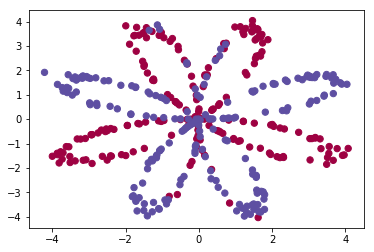

In [19]:
#打印数据
plt.scatter(x[:, 0], x[:, 1], c=y.reshape(-1), s=40, cmap=plt.cm.Spectral)

In [20]:
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

In [21]:
# Sequential
seq_net = nn.Sequential(
    nn.Linear(2,4),#Pytorch 中的线性层 wx + b
    nn.Tanh(),
    nn.Linear(4,1)
)

In [22]:
#使用内置的逻辑回归Loss
criterion = nn.BCEWithLogitsLoss()

In [23]:
# 序列模块可以通过索引访问每一层

seq_net[0] # 第一层

Linear(in_features=2, out_features=4)

In [24]:
# 打印出第一层的权重

w0 = seq_net[0].weight
print(w0)

Parameter containing:
-0.1069  0.4828
-0.4046  0.2079
 0.2560 -0.0530
-0.4806 -0.3888
[torch.FloatTensor of size 4x2]



In [25]:
# 通过 parameters 可以取得模型的参数
param = seq_net.parameters()

# 定义优化器
optim = torch.optim.SGD(param, 1.)

In [26]:
for e in range(10000):
    out = seq_net(Variable(x))
    loss = criterion(out,Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (e+1) % 1000 == 0:
        print('epoch:{},loss:{}'.format(e+1,loss.data[0]))

epoch:1000,loss:0.28373274207115173
epoch:2000,loss:0.27167099714279175
epoch:3000,loss:0.2647441327571869
epoch:4000,loss:0.26002219319343567
epoch:5000,loss:0.2566456198692322
epoch:6000,loss:0.25414198637008667
epoch:7000,loss:0.2522262632846832
epoch:8000,loss:0.2507207989692688
epoch:9000,loss:0.2495109587907791
epoch:10000,loss:0.24851994216442108


可以看到，训练 10000 次 loss 比之前的更低，这是因为 PyTorch 自带的模块比我们写的更加稳定。
同时也有一些初始化的问题在里面，关于参数初始化，会在后面讲到

In [27]:
def plot_decision_boundary(model,x,y):
    #设置最大值与最小值，再给他们一些padding
    x_min,x_max = x[:,0].min() - 1,x[:,0].max() + 1#最小值减了1，最大值加了1
    y_min,y_max = x[:,1].min() - 1,x[:,1].max() + 1#最小值减了1，最大值加了1
   
    h = 0.01#间距
    #生成一系列间距为h的点
    xx,yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))
    #预测整个网络的值
    Z = model(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    #绘制边界和训练集示例
    plt.contourf(xx,yy,Z, cmap = plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(x[:,0],x[:,1],c=y.reshape(-1),s=40,cmap=plt.cm.Spectral)  

In [28]:
def plot_seq(x):
    out = F.sigmoid(seq_net(Variable(torch.from_numpy(x).float()))).data.numpy()
    out = (out > 0.5) * 1
    return out    

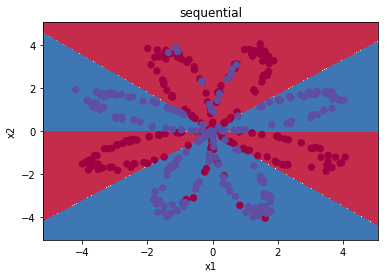

In [29]:
plot_decision_boundary(lambda x: plot_seq(x), x.numpy(), y.numpy())
plt.title('sequential')

## 如何保存模型

保存模型在 PyTorch 中有两种方式，一种是将模型结构和参数都保存在一起，一种是只将参数保存下来，下面一一介绍。

In [30]:
# 将参数和模型保存在一起
torch.save(seq_net, 'save_seq_net.pth')

上面就是保存模型的方式，`torch.save`里面有两个参数，第一个是要保存的模型，第二个参数是保存的路径，读取模型的方式也非常简单

In [31]:
# 读取保存的模型
seq_net1 = torch.load('save_seq_net.pth')

In [32]:
seq_net1

Sequential(
  (0): Linear(in_features=2, out_features=4)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=1)
)

In [33]:
print(seq_net1[0].weight)

Parameter containing:
-10.3189  12.9297
 -0.5513  -1.9861
 -0.0446  -7.9422
-10.0670 -11.7743
[torch.FloatTensor of size 4x2]



我们可以看到我们重新读入了模型，并且将其命名为 seq_net1，并且打印了第一层的参数

下面我们看看第二种保存模型的方式，只保存参数而不保存模型结构

In [34]:
# 保存模型参数
torch.save(seq_net.state_dict(), 'save_seq_net_params.pth')

通过上面的方式，保存了模型的参数，如果要重新读入模型的参数，我们需要重新定义一次模型，接着重新读入参数

In [35]:
seq_net2 = nn.Sequential(
    nn.Linear(2, 4),
    nn.Tanh(),
    nn.Linear(4, 1)
)

seq_net2.load_state_dict(torch.load('save_seq_net_params.pth'))

In [36]:
seq_net2

Sequential(
  (0): Linear(in_features=2, out_features=4)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=1)
)

In [37]:
print(seq_net2[0].weight)

Parameter containing:
-10.3189  12.9297
 -0.5513  -1.9861
 -0.0446  -7.9422
-10.0670 -11.7743
[torch.FloatTensor of size 4x2]



通过这种方式我们也重新读入了相同的模型，打印第一层的参数对比，发现和前面的办法是一样的

有这两种保存和读取模型的方法，推荐使用**第二种**，因为第二种可移植性更强

下面我们再用 Module 定义这个模型，下面是使用 Module 的模板

```
class 网络名字(nn.Module):
    def __init__(self, 一些定义的参数):
        super(网络名字, self).__init__()
        self.layer1 = nn.Linear(num_input, num_hidden)
        self.layer2 = nn.Sequential(...)
        ...
        
        定义需要用的网络层
        
    def forward(self, x): # 定义前向传播
        x1 = self.layer1(x)
        x2 = self.layer2(x)
        x = x1 + x2
        ...
        return x
```

注意的是，Module 里面也可以使用 Sequential，同时 Module 非常灵活，具体体现在 forward 中，如何复杂的操作都能直观的在 forward 里面执行

下面我们照着模板实现一下上面的神经网络

In [40]:
class module_net(nn.Module):
    def __init__(self,num_input,num_hidden,num_output):
        super(module_net,self).__init__()
        
        self.layer1 = nn.Linear(num_input,num_hidden)
        
        self.layer2 = nn.Tanh()
        
        self.layer3 = nn.Linear(num_hidden,num_output)
        
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [41]:
mo_net = module_net(2,4,1)

In [42]:
# 访问模型中的某层可以直接通过名字

# 第一层
l1 = mo_net.layer1
print(l1)

Linear(in_features=2, out_features=4)


In [43]:
# 打印出第一层的权重
print(l1.weight)

Parameter containing:
-0.5829 -0.4389
 0.1693  0.1012
-0.0626  0.3152
 0.1548 -0.1631
[torch.FloatTensor of size 4x2]



In [44]:
# 定义优化器
optim = torch.optim.SGD(mo_net.parameters(), 1.)

In [45]:
# 训练 10000 次
for e in range(10000):
    out = mo_net(Variable(x))
    loss = criterion(out, Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (e + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.data[0]))

epoch: 1000, loss: 0.2836572825908661
epoch: 2000, loss: 0.27163225412368774
epoch: 3000, loss: 0.2647137939929962
epoch: 4000, loss: 0.25999876856803894
epoch: 5000, loss: 0.25662821531295776
epoch: 6000, loss: 0.2541293203830719
epoch: 7000, loss: 0.25221702456474304
epoch: 8000, loss: 0.25071394443511963
epoch: 9000, loss: 0.24950569868087769
epoch: 10000, loss: 0.24851582944393158


In [46]:
# 保存模型
torch.save(mo_net.state_dict(), 'module_net.pth')

可以看到我们得到了相同的结果，而且使用 Sequential 和 Module 来定义模型更加方便

在这一节中我们还是使用梯度下降法来优化参数，在神经网络中，这种优化方法有一个特别的名字，反向传播算法，下一次课我们会讲一讲什么是反向传播算法

**小练习：改变网络的隐藏层神经元数目，或者试试定义一个 5 层甚至更深的模型，增加训练次数，改变学习率，看看结果会怎么样**

下面举个例子

In [48]:
net = nn.Sequential(
    nn.Linear(2, 10),
    nn.Tanh(),
    nn.Linear(10, 10),
    nn.Tanh(),
    nn.Linear(10, 10),
    nn.Tanh(),
    nn.Linear(10, 1)
)

optim = torch.optim.SGD(net.parameters(), 0.1)

In [49]:
# 我们训练 20000 次
for e in range(20000):
    out = net(Variable(x))
    loss = criterion(out, Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (e + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.data[0]))

epoch: 1000, loss: 0.28734198212623596
epoch: 2000, loss: 0.2419530749320984
epoch: 3000, loss: 0.2182968556880951
epoch: 4000, loss: 0.2046152502298355
epoch: 5000, loss: 0.19643746316432953
epoch: 6000, loss: 0.190973162651062
epoch: 7000, loss: 0.18679861724376678
epoch: 8000, loss: 0.18317881226539612
epoch: 9000, loss: 0.1796794980764389
epoch: 10000, loss: 0.1762002408504486
epoch: 11000, loss: 0.17302599549293518
epoch: 12000, loss: 0.17013917863368988
epoch: 13000, loss: 0.1675327718257904
epoch: 14000, loss: 0.16518105566501617
epoch: 15000, loss: 0.16299772262573242
epoch: 16000, loss: 0.1608700007200241
epoch: 17000, loss: 0.15867826342582703
epoch: 18000, loss: 0.15632033348083496
epoch: 19000, loss: 0.15376554429531097
epoch: 20000, loss: 0.15108619630336761


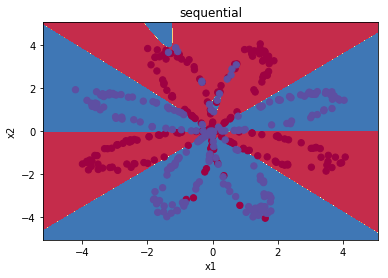

In [50]:
def plot_net(x):
    out = F.sigmoid(net(Variable(torch.from_numpy(x).float()))).data.numpy()
    out = (out > 0.5) * 1
    return out

plot_decision_boundary(lambda x: plot_net(x), x.numpy(), y.numpy())
plt.title('sequential')